In [1]:
import tensorflow as tf
import numpy as np
import sys
from datetime import datetime
from functools import partial
from utils import *

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

MODEL_PATH = "models/autoencoder/"

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))

x = Conv2D(24, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(12, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(24, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [5]:
from tensorflow.keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=150,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 116s 2ms/sample - loss: 0.6936 - val_loss: 0.6920
Epoch 2/150
60000/60000 [==============================] - 123s 2ms/sample - loss: 0.6902 - val_loss: 0.6881
Epoch 3/150
60000/60000 [==============================] - 144s 2ms/sample - loss: 0.6853 - val_loss: 0.6819
Epoch 4/150
60000/60000 [==============================] - 146s 2ms/sample - loss: 0.6764 - val_loss: 0.6693
Epoch 5/150
60000/60000 [==============================] - 147s 2ms/sample - loss: 0.6549 - val_loss: 0.6336
Epoch 6/150
60000/60000 [==============================] - 143s 2ms/sample - loss: 0.5851 - val_loss: 0.5261
Epoch 7/150
60000/60000 [==============================] - 141s 2ms/sample - loss: 0.4970 - val_loss: 0.4896
Epoch 8/150
60000/60000 [==============================] - 141s 2ms/sample - loss: 0.4818 - val_loss: 0.4813
Epoch 9/150
60000/60000 [==============================] - 149s 2ms/sample - l

In [7]:
# saving model
autoencoder.save(MODEL_PATH + 'autoencoder.h5')

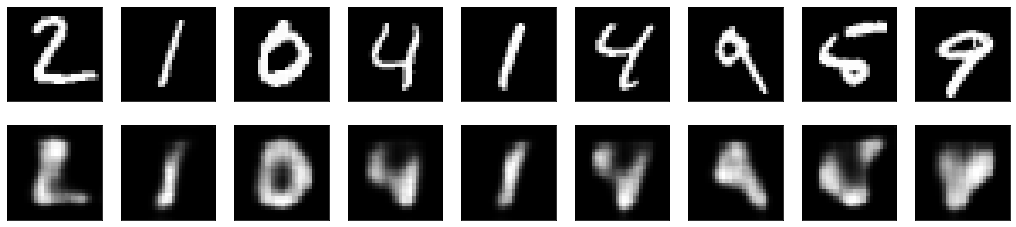

In [6]:
decoded_imgs = autoencoder.predict(x_test[:10])

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Restore model used for unsupervised pre-training

In [30]:
pretrained_autoencoder = keras.models.load_model(MODEL_PATH + 'autoencoder.h5')
pretrained_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 8)           0   

### adding layers at the end of the pretrained model

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [32]:
x = pretrained_autoencoder.output
# Adding a fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dense(200, activation='relu')(x)
# Adding a fully connected layer for the 10 classes 0 to 9
predictions = Dense(10, activation='softmax')(x)

### freezing model

In [33]:
model = Model(inputs=pretrained_autoencoder.input, outputs=predictions)

# freeze all layers of the pre-trained model
# we will only train the Dense layers added in "model"
for layer in pretrained_autoencoder.layers:
    layer.trainable = False

# compile the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])